<a href="https://colab.research.google.com/github/iakkii/CNNProject/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Getting the dataset**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0.zip" -d "/content/sample_data/"

#**GettingData**
using MIT-BIH 

to use wfdb package

In [0]:
pip install wfdb

In [0]:
from glob import glob
import wfdb
import numpy as np

In [0]:
def getRecords() :
  paths = glob('/content/sample_data/mitdb/*.atr')
  paths = [path[:-4] for path in paths]
  paths.sort()
  return paths

Annotation:

'N' for normal beats. 
'L' for left bundle branch block beats. 
'R' for right bundle branch block beats. 
'A' for Atrial premature contraction. 
'V' for ventricular premature contraction. 
'/' for paced beat. 
'E' for Ventricular escape beat.

In [0]:
def beat_annotations(annotation,label):
    ids = np.in1d(annotation.symbol, label)
    beats = annotation.sample[ids]
    return beats

In [0]:
def findSignalRange(beats, beatSubList, signalRange):
    for i in beatSubList:
        beats = list(beats)
        j = beats.index(i)
        if(j!=0 and j!=(len(beats)-1)):
            x = beats[j-1]
            y = beats[j+1]
            diff1 = abs(x - beats[j])//2
            diff2 = abs(y - beats[j])//2
            signalRange.append(signals[beats[j] - diff1: beats[j] + diff2,0])
    return signalRange

Segmentation

In [0]:
def segmentation():
  records = getRecords()
  normal = []
  abnormal = []
  for e in records:
    signals,fields = wfdb.rdsamp(e, channels = [0])
    ann = wfdb.rdann(e, 'atr')
    imp_beats = beat_annotations(ann, ['N'])
    beats = (ann.sample)
    normal = findSignalRange(beats, imp_beats, normal)
    unimp_beats = np.setdiff1d(ann.sample,imp_beats, assume_unique = True)
    abnormal = findSignalRange(beats, unimp_beats, abnormal)
  return normal, abnormal

ECG to Images

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
import wfdb

In [0]:
kernel = np.ones((4,4),np.uint8)
def ecgToImg():
  normal, abnormal = segmentation()
  print(len(normal),len(abnormal))
  for count, i in enumerate(normal[:500]):
    fig = plt.figure(frameon=True)
    plt.plot(i)
    plt.xticks([]), plt.yticks([])
    for spine in plt.gca().spines.values():
      spine.set_visible(False)

    filename = '/content/sample_data/input/normal' +str(count)+ '.png'
    fig.savefig(filename)
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im_gray = cv2.erode(im_gray,kernel,iterations = 1)
    im_gray = cv2.resize(im_gray, (128,128), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(filename, im_gray)

  for count, i in enumerate(abnormal[:500]):
    fig = plt.figure(frameon=True)
    plt.plot(i)
    plt.xticks([]), plt.yticks([])
    for spine in plt.gca().spines.values():
      spine.set_visible(False)

    filename = '/content/sample_data/input/ab' +str(count)+ '.png'
    fig.savefig(filename)
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im_gray = cv2.erode(im_gray,kernel,iterations = 1)
    im_gray = cv2.resize(im_gray, (128,128), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(filename, im_gray)

In [0]:
ecgToImg()

Splitting the images

In [0]:
import os
import random
import gc
from sklearn.model_selection import train_test_split

In [0]:
path = '/content/drive/My Drive/input'
norm = ['/content/drive/My Drive/input/{}'.format(i) for i in os.listdir(path) if 'normal' in i]
abnorm = ['/content/drive/My Drive/input/{}'.format(i) for i in os.listdir(path) if 'ab' in i]

In [0]:
train_imgs = norm + abnorm
random.shuffle(train_imgs)  # shuffle it randomly

In [0]:
del norm
del abnorm
gc.collect()

In [0]:
X = []
y = []
for image in train_imgs:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (128,128), interpolation=cv2.INTER_CUBIC)) 
        #get the labels
    if 'normal' in image:
        y.append(1)
    elif 'ab' in image:
        y.append(0)

In [16]:
X = np.array(X)
y = np.array(y)
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (1000, 128, 128)
Shape of labels is: (1000,)


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

ntrain = len(X_train)
nval = len(X_val)

batch_size = 64
X_train = X_train.reshape(-1, 128, 128, 1)   #Reshape for CNN -  should work!!
X_val = X_val.reshape(-1, 128, 128, 1)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)


In [18]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
import keras
from keras.layers import Dense, Flatten, Dropout, MaxPool2D

Using TensorFlow backend.


In [19]:
model = Sequential()

model.add(Conv2D(64, (3,3),strides = (1,1), input_shape=(128,128,1), kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(64, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Flatten())

model.add(Dense(2048))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
elu_1 (ELU)                  (None, 126, 126, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
elu_2 (ELU)                  (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      25

In [22]:

model.fit(X_train,y_train,batch_size= batch_size, epochs=20, validation_data=(X_val,y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/20
700/700 [==============================] - 281s 401ms/step - loss: 0.0681 - acc: 0.9929 - val_loss: 2.1008 - val_acc: 0.7000
Epoch 2/20
700/700 [==============================] - 283s 404ms/step - loss: 0.0232 - acc: 0.9986 - val_loss: 5.3705 - val_acc: 0.5200
Epoch 3/20
700/700 [==============================] - 284s 405ms/step - loss: 0.0248 - acc: 0.9986 - val_loss: 0.0532 - val_acc: 0.9867
Epoch 4/20
700/700 [==============================] - 285s 407ms/step - loss: 0.0234 - acc: 0.9986 - val_loss: 0.0193 - val_acc: 0.9967
Epoch 5/20
700/700 [==============================] - 283s 404ms/step - loss: 0.0231 - acc: 0.9986 - val_loss: 0.0078 - val_acc: 0.9967
Epoch 6/20
700/700 [==============================] - 281s 402ms/step - loss: 0.0230 - acc: 0.9986 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 7/20
700/700 [==============================] - 282s 403ms/step - loss: 0.0237 - acc: 0.9986 - val_loss: 6.6761e-05 - val_acc: 1.000

Saving the model

In [0]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

Using the model

In [0]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image

In [28]:
model = load_model('model_keras.h5')
model._make_predict_function()          # Necessary
print('Model loaded. Start serving...')

Model loaded. Start serving...


1


ValueError: ignored

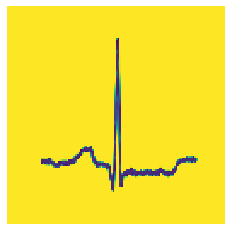

In [0]:
AB, N = [], []
result = {"AB": AB, "N": N}

for count, i in enumerate(X_val[:3]):
  print(y_val[count])
  fig = plt.figure(frameon=False)
  plt.imshow(np.squeeze(i)) 
  plt.xticks([]), plt.yticks([])
  for spine in plt.gca().spines.values():
    spine.set_visible(False)

  filename = 'fig' + '.png'
  fig.savefig(filename)
  im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  im_gray = cv2.erode(im_gray,kernel,iterations = 1)
  im_gray = cv2.resize(im_gray,(128,128),1)
  im_gray = cv2.resize(im_gray, (128, 128), interpolation = cv2.INTER_CUBIC)
  cv2.imwrite(filename, im_gray)
  pred = model.predict(im_gray.reshape((128, 128, 3)))
  pred_class = pred.argmax(axis=-1)
  if pred_class == 0:
    print('Abnormal') 
  elif pred_class == 1:
    print('Normal')
  os.remove('fig.png')